In [7]:
#next research XGBoost RF and implement and compare

#Most important features: repeated_guest, no_of_previous... (x2), avg_price_per_room

#Could do things like look for parties that schedule a booking at the same time each year

#no_of_previous_bookings_not_canceled feature suggets that the one time bookers are the most 
#likely to cancel.

#no_of_previous_cancellations has someone who canceled 13 times... maybe they are a bot or something and
#maybe they are related to the phenomenon in the scatterplot

In [8]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_fscore_support as score

import xgboost as xgb
import graphviz

In [9]:
#read in data
df = pd.read_csv('Hotel Reservations.csv')

In [10]:
cols = {}
for col in df.columns:
    cols[col] = type(df.loc[0,col])
    
print(pd.DataFrame.from_dict(cols, orient='index'))
df.describe().round(2)


                                                            0
Booking_ID                                      <class 'str'>
no_of_adults                            <class 'numpy.int64'>
no_of_children                          <class 'numpy.int64'>
no_of_weekend_nights                    <class 'numpy.int64'>
no_of_week_nights                       <class 'numpy.int64'>
type_of_meal_plan                               <class 'str'>
required_car_parking_space              <class 'numpy.int64'>
room_type_reserved                              <class 'str'>
lead_time                               <class 'numpy.int64'>
arrival_year                            <class 'numpy.int64'>
arrival_month                           <class 'numpy.int64'>
arrival_date                            <class 'numpy.int64'>
market_segment_type                             <class 'str'>
repeated_guest                          <class 'numpy.int64'>
no_of_previous_cancellations            <class 'numpy.int64'>
no_of_pr

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00,36275.00
mean,1.84,0.11,0.81,2.20,0.03,85.23,2017.82,7.42,15.60,0.03,0.02,0.15,103.42,0.62
std,0.52,0.40,0.87,1.41,0.17,85.93,0.38,3.07,8.74,0.16,0.37,1.75,35.09,0.79
min,0.00,0.00,0.00,0.00,0.00,0.00,2017.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,2.00,0.00,0.00,1.00,0.00,17.00,2018.00,5.00,8.00,0.00,0.00,0.00,80.30,0.00
50%,2.00,0.00,1.00,2.00,0.00,57.00,2018.00,8.00,16.00,0.00,0.00,0.00,99.45,0.00
75%,2.00,0.00,2.00,3.00,0.00,126.00,2018.00,10.00,23.00,0.00,0.00,0.00,120.00,1.00
max,4.00,10.00,7.00,17.00,1.00,443.00,2018.00,12.00,31.00,1.00,13.00,58.00,540.00,5.00


In [11]:
df.loc[0,:]

Booking_ID                                  INN00001
no_of_adults                                       2
no_of_children                                     0
no_of_weekend_nights                               1
no_of_week_nights                                  2
type_of_meal_plan                        Meal Plan 1
required_car_parking_space                         0
room_type_reserved                       Room_Type 1
lead_time                                        224
arrival_year                                    2017
arrival_month                                     10
arrival_date                                       2
market_segment_type                          Offline
repeated_guest                                     0
no_of_previous_cancellations                       0
no_of_previous_bookings_not_canceled               0
avg_price_per_room                              65.0
no_of_special_requests                             0
booking_status                          Not_Ca

In [12]:
#categorical data
print(df.groupby('type_of_meal_plan').size())
print('---------------------------')
print(df.groupby('room_type_reserved').size())
print('---------------------------')
print(df.groupby('market_segment_type').size())
print('---------------------------')
print(df.groupby('booking_status').size())

type_of_meal_plan
Meal Plan 1     27835
Meal Plan 2      3305
Meal Plan 3         5
Not Selected     5130
dtype: int64
---------------------------
room_type_reserved
Room_Type 1    28130
Room_Type 2      692
Room_Type 3        7
Room_Type 4     6057
Room_Type 5      265
Room_Type 6      966
Room_Type 7      158
dtype: int64
---------------------------
market_segment_type
Aviation           125
Complementary      391
Corporate         2017
Offline          10528
Online           23214
dtype: int64
---------------------------
booking_status
Canceled        11885
Not_Canceled    24390
dtype: int64


In [13]:
df['booking_status_bln'] = df['booking_status'].apply(lambda x: True if x == 'Canceled' else False)

In [14]:
df_bs = df.groupby('booking_status').size()

print('Proportion of all reservations cancelled: ' + str(df_bs['Canceled']/len(df)))
print('-------------------------')

#proportion of reservations in each category that cancelled
for col in df.columns[1:]:
    print(df.groupby(col).apply(lambda x: x['booking_status_bln'].sum()/len(x)))
    print('-------------------------')



#print(df.groupby('type_of_meal_plan').apply(lambda x: x['booking_status_bln'].sum()/len(x)))
#print('-------------------------')
#print(df.groupby('room_type_reserved').apply(lambda x: x['booking_status_bln'].sum()/len(x)))
#print('-------------------------')
#print(df.groupby('market_segment_type').apply(lambda x: x['booking_status_bln'].sum()/len(x)))

Proportion of all reservations cancelled: 0.32763611302549966
-------------------------
no_of_adults
0    0.316547
1    0.241196
2    0.349280
3    0.372464
4    0.187500
dtype: float64
-------------------------
no_of_children
0     0.324091
1     0.333745
2     0.431947
3     0.263158
9     0.500000
10    0.000000
dtype: float64
-------------------------
no_of_weekend_nights
0    0.301861
1    0.343372
2    0.348032
3    0.483660
4    0.643411
5    0.852941
6    0.800000
7    1.000000
dtype: float64
-------------------------
no_of_week_nights
0     0.284457
1     0.271079
2     0.349266
3     0.328358
4     0.382274
5     0.391574
6     0.465608
7     0.460177
8     0.516129
9     0.617647
10    0.854839
11    0.823529
12    0.777778
13    1.000000
14    0.571429
15    0.800000
16    1.000000
17    0.666667
dtype: float64
-------------------------
type_of_meal_plan
Meal Plan 1     0.311802
Meal Plan 2     0.455673
Meal Plan 3     0.200000
Not Selected    0.331189
dtype: float64
------

In [15]:
#example to automate the ordinal categorical variable encoding
col = 'room_type_reserved'
room_df = df.groupby(col).apply(lambda x: x['booking_status_bln'].sum()/len(x))
room_df.sort_values(ascending = False, inplace = True)
room_df = room_df.to_frame()
room_df.insert(0, 'New_ID', range(1,1+len(room_df)))
room_df = room_df['New_ID'].to_dict()
room_df

{'Room_Type 6': 1,
 'Room_Type 4': 2,
 'Room_Type 2': 3,
 'Room_Type 1': 4,
 'Room_Type 3': 5,
 'Room_Type 5': 6,
 'Room_Type 7': 7}

In [16]:
#data cleaning
df.isna().any()
#data clean

Booking_ID                              False
no_of_adults                            False
no_of_children                          False
no_of_weekend_nights                    False
no_of_week_nights                       False
type_of_meal_plan                       False
required_car_parking_space              False
room_type_reserved                      False
lead_time                               False
arrival_year                            False
arrival_month                           False
arrival_date                            False
market_segment_type                     False
repeated_guest                          False
no_of_previous_cancellations            False
no_of_previous_bookings_not_canceled    False
avg_price_per_room                      False
no_of_special_requests                  False
booking_status                          False
booking_status_bln                      False
dtype: bool

### Feature Engineering

In [17]:
date_df = df[['arrival_year','arrival_month','arrival_date']].rename(columns = {'arrival_year':'year','arrival_month':'month','arrival_date':'day'})
df['time'] = pd.to_datetime(date_df, errors = 'coerce')

In [18]:
#data encoding
str_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']
en_cols = ['meal_en', 'room_en', 'market_en']

#trying to automate the labeling
for i in range(3):
    col = str_cols[i]
    en_col = en_cols[i]
    
    en_df = df.groupby(col).apply(lambda x: x['booking_status_bln'].sum()/len(x))
    en_df.sort_values(ascending = False, inplace = True)
    en_df = en_df.to_frame()
    en_df.insert(0, 'New_ID', range(1,1+len(en_df)))
    en_dict = en_df['New_ID'].to_dict()
    
    df[en_col] = df[col].map(en_dict)

In [19]:
df[['type_of_meal_plan','meal_en']].head()
#df[['room_type_reserved','room_en']].head(50)
#df[['market_segment_type','market_en']].head(50)

,type_of_meal_plan,meal_en
0,Meal Plan 1,3
1,Not Selected,2
2,Meal Plan 1,3
3,Meal Plan 1,3
4,Not Selected,2


In [20]:
cols = df.columns

i = 0
for col in cols:
    print(i,col)
    i+=1

0 Booking_ID
1 no_of_adults
2 no_of_children
3 no_of_weekend_nights
4 no_of_week_nights
5 type_of_meal_plan
6 required_car_parking_space
7 room_type_reserved
8 lead_time
9 arrival_year
10 arrival_month
11 arrival_date
12 market_segment_type
13 repeated_guest
14 no_of_previous_cancellations
15 no_of_previous_bookings_not_canceled
16 avg_price_per_room
17 no_of_special_requests
18 booking_status
19 booking_status_bln
20 time
21 meal_en
22 room_en
23 market_en


### Model Training

In [21]:
feats = cols[[1,2,3,4,6,8,9,10,11,13,14,15,16,17,21,22,23]]
X = df[feats]
y = df[cols[19]]

In [22]:
mms = MinMaxScaler()
X_scaled = mms.fit_transform(X)
X_scaled

array([[0.5       , 0.        , 0.14285714, ..., 0.66666667, 0.5       ,
        0.25      ],
       [0.5       , 0.        , 0.28571429, ..., 0.33333333, 0.5       ,
        0.        ],
       [0.25      , 0.        , 0.28571429, ..., 0.66666667, 0.5       ,
        0.        ],
       ...,
       [0.5       , 0.        , 0.28571429, ..., 0.66666667, 0.5       ,
        0.        ],
       [0.5       , 0.        , 0.        , ..., 0.33333333, 0.5       ,
        0.        ],
       [0.5       , 0.        , 0.14285714, ..., 0.66666667, 0.5       ,
        0.25      ]])

In [23]:
#train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size = .8, random_state = 0)

In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_test_df = pd.DataFrame(X_test)
X_test_df

(29020, 17)
(7255, 17)
(29020,)
(7255,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.75,0.0,0.285714,0.176471,0.0,0.049661,1.0,0.272727,0.433333,0.0,0.0,0.0,0.282593,0.4,0.666667,0.166667,0.00
1,0.50,0.0,0.000000,0.176471,0.0,0.435666,0.0,0.818182,0.466667,0.0,0.0,0.0,0.120370,0.0,0.666667,0.500000,0.25
2,0.50,0.0,0.000000,0.117647,0.0,0.580135,0.0,0.545455,0.000000,0.0,0.0,0.0,0.187963,0.0,0.000000,0.500000,0.25
3,0.50,0.0,0.285714,0.235294,0.0,0.015801,1.0,0.454545,0.500000,0.0,0.0,0.0,0.288889,0.2,0.666667,0.166667,0.00
4,0.50,0.0,0.000000,0.117647,0.0,0.088036,0.0,0.636364,0.433333,0.0,0.0,0.0,0.187963,0.0,0.000000,0.500000,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7250,0.50,0.0,0.285714,0.176471,0.0,0.198646,1.0,0.727273,0.466667,0.0,0.0,0.0,0.276667,0.2,0.666667,0.166667,0.00
7251,0.50,0.0,0.285714,0.000000,0.0,0.024831,1.0,0.454545,0.833333,0.0,0.0,0.0,0.214815,0.0,0.666667,0.500000,0.00
7252,0.50,0.0,0.000000,0.117647,0.0,0.117381,1.0,0.090909,0.600000,0.0,0.0,0.0,0.145000,0.2,0.666667,0.500000,0.00
7253,0.25,0.0,0.285714,0.000000,0.0,0.072235,1.0,1.000000,0.100000,0.0,0.0,0.0,0.211111,0.0,0.666667,0.166667,0.00


In [25]:
#DT/RF model
#smaller ccp_alpha gives deeper trees (limited by max_depth)

dt = DecisionTreeClassifier(max_depth=4, ccp_alpha=0.01, criterion='entropy')
dt.fit(X_train, y_train)
print('Training Score: ' + str(dt.score(X_train, y_train)))

print('Test Score: ' + str((dt.score(X_test, y_test))))

Training Score: 0.8155410062026189
Test Score: 0.8205375603032391


In [26]:
#feature importances
feat_imp_L = [[feats[i],dt.feature_importances_[i]] for i in range(len(feats))]
feat_imp_df = pd.DataFrame(data = feat_imp_L).sort_values(ascending = False, by = 1).reset_index(drop = True)
feat_imp_df

,0,1
0,lead_time,0.471006
1,market_en,0.208341
2,no_of_special_requests,0.176266
3,avg_price_per_room,0.108347
4,arrival_month,0.036041
5,no_of_previous_cancellations,0.000000
6,room_en,0.000000
7,meal_en,0.000000
8,no_of_previous_bookings_not_canceled,0.000000
9,no_of_adults,0.000000


|--- lead_time <= 0.34
|   |--- no_of_special_requests <= 0.10
|   |   |--- market_en <= 0.12
|   |   |   |--- lead_time <= 0.02
|   |   |   |   |--- weights: [1085.00, 283.00] class: 0.0
|   |   |   |--- lead_time >  0.02
|   |   |   |   |--- weights: [1776.00, 2827.00] class: 1.0
|   |   |--- market_en >  0.12
|   |   |   |--- lead_time <= 0.17
|   |   |   |   |--- weights: [4068.00, 336.00] class: 0.0
|   |   |   |--- lead_time >  0.17
|   |   |   |   |--- weights: [1253.00, 564.00] class: 0.0
|   |--- no_of_special_requests >  0.10
|   |   |--- weights: [9760.00, 1343.00] class: 0.0
|--- lead_time >  0.34
|   |--- avg_price_per_room <= 0.19
|   |   |--- no_of_special_requests <= 0.10
|   |   |   |--- market_en <= 0.12
|   |   |   |   |--- weights: [18.00, 708.00] class: 1.0
|   |   |   |--- market_en >  0.12
|   |   |   |   |--- weights: [766.00, 741.00] class: 0.0
|   |   |--- no_of_special_requests >  0.10
|   |   |   |--- weights: [689.00, 274.00] class: 0.0
|   |--- avg_price_p

[Text(0.5294117647058824, 0.9, 'lead_time <= 0.342\nentropy = 0.912\nsamples = 29020\nvalue = [19536, 9484]\nclass = Cancelled'),
 Text(0.29411764705882354, 0.7, 'no_of_special_requests <= 0.1\n0.778\n23295\n[17942, 5353]\nCancelled'),
 Text(0.23529411764705882, 0.5, 'market_en <= 0.125\n0.914\n12192\n[8182, 4010]\nCancelled'),
 Text(0.11764705882352941, 0.3, 'lead_time <= 0.021\n0.999\n5971\n[2861, 3110]\nNot Cancelled'),
 Text(0.058823529411764705, 0.1, '0.735\n1368\n[1085, 283]\nCancelled'),
 Text(0.17647058823529413, 0.1, '0.962\n4603\n[1776, 2827]\nNot Cancelled'),
 Text(0.35294117647058826, 0.3, 'lead_time <= 0.168\n0.596\n6221\n[5321, 900]\nCancelled'),
 Text(0.29411764705882354, 0.1, '0.389\n4404\n[4068, 336]\nCancelled'),
 Text(0.4117647058823529, 0.1, '0.894\n1817\n[1253, 564]\nCancelled'),
 Text(0.35294117647058826, 0.5, '0.532\n11103\n[9760, 1343]\nCancelled'),
 Text(0.7647058823529411, 0.7, 'avg_price_per_room <= 0.185\n0.853\n5725\n[1594, 4131]\nNot Cancelled'),
 Text(0.6

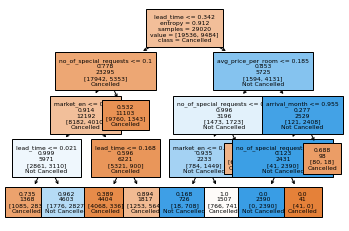

In [27]:
#plot tree
print(tree.export_text(dt, feature_names = feats.to_list(), show_weights = True))
tree.plot_tree(dt, feature_names = feats,  
               max_depth=10, class_names = ['Cancelled', 'Not Cancelled'],
               label='root', filled=True, fontsize = 6)


In [28]:
# At 300+ days there are days where everyone and no one cancels...

df_group_lead = df.groupby('lead_time').apply(lambda x: x['booking_status_bln'].sum()/len(x))
df_group_lead = pd.DataFrame(df_group_lead)
df_group_lead['count'] = df.groupby('lead_time').apply(lambda x: len(x))
df_group_lead['num_cancelled'] = df.groupby('lead_time').apply(lambda x: x['booking_status_bln'].sum())

df_group_lead.reset_index(drop = False)
df_group_lead.rename(columns = {0:'prop'}, inplace = True)

In [29]:
#on many of the late lead time there are little to no reservations, which explains the scatterplot behavior
df_group_lead.tail(5)

,prop,count,num_cancelled
lead_time,,,
381,1.000000,2,2
386,0.913043,69,63
418,1.000000,60,60
433,1.000000,20,20
443,1.000000,22,22


In [30]:
df[df['lead_time'] > 400].tail()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,...,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,booking_status_bln,time,meal_en,room_en,market_en
35189,INN35190,2,0,1,2,Meal Plan 1,0,Room_Type 1,418,2018,...,0,0,75.0,0,Canceled,True,2018-09-26,3,4,2
35241,INN35242,2,0,0,3,Meal Plan 1,0,Room_Type 1,433,2018,...,0,0,70.0,0,Canceled,True,2018-09-08,3,4,2
35369,INN35370,2,0,1,2,Meal Plan 2,0,Room_Type 1,418,2018,...,0,0,107.0,0,Canceled,True,2018-09-26,1,4,2
35594,INN35595,2,0,1,2,Meal Plan 2,0,Room_Type 1,418,2018,...,0,0,107.0,0,Canceled,True,2018-09-26,1,4,2
35656,INN35657,2,0,0,1,Meal Plan 1,0,Room_Type 1,443,2018,...,0,0,65.0,0,Canceled,True,2018-04-29,3,4,2


In [31]:
#train DT model with KFold and hyperparam search

dt = DecisionTreeClassifier(max_depth=4, ccp_alpha=0.01, criterion='entropy')
cv = KFold(5, shuffle=True)
params = {"max_depth" : [4,10,100,1000], "ccp_alpha":np.logspace(-6,0,7)} # this should be a dictionary {"param_name" : [param, options, ...]}

gcv = GridSearchCV(estimator=dt, cv=cv, param_grid=params)

In [32]:
gcv.fit(X_train, y_train)
gcv.cv_results_

{'mean_fit_time': array([0.03464198, 0.06190839, 0.09511762, 0.09557462, 0.03226581,
        0.0595962 , 0.09364433, 0.09479828, 0.0416151 , 0.06231089,
        0.09733472, 0.09836173, 0.03205938, 0.06110735, 0.11397824,
        0.11899986, 0.03397684, 0.0614203 , 0.11323633, 0.12527437,
        0.03257384, 0.06120863, 0.11450276, 0.11340814, 0.03227015,
        0.06049457, 0.11137786, 0.1106791 ]),
 'std_fit_time': array([0.0029304 , 0.00317154, 0.00180271, 0.00375866, 0.00047758,
        0.00212578, 0.00542419, 0.00286231, 0.00279622, 0.00522237,
        0.0019295 , 0.00183512, 0.00140818, 0.00132478, 0.00259471,
        0.00754505, 0.0009419 , 0.00116915, 0.00444411, 0.00540497,
        0.00075909, 0.00255805, 0.00320503, 0.00086387, 0.00127244,
        0.00154693, 0.00193838, 0.00126569]),
 'mean_score_time': array([0.00199676, 0.00220308, 0.00239034, 0.00225825, 0.00182233,
        0.00205221, 0.00266223, 0.00256634, 0.00227423, 0.00205388,
        0.00263309, 0.00245705, 0.002003

In [33]:
dt_best = gcv.best_estimator_

print(dt_best.get_params)
print('Training Score: ' + str(dt_best.score(X_train, y_train)))
print('Test Score: ' + str((dt_best.score(X_test, y_test))))
print('Decision Tree Depth: ' + str(dt_best.get_depth()))

<bound method BaseEstimator.get_params of DecisionTreeClassifier(ccp_alpha=0.0001, criterion='entropy', max_depth=1000)>
Training Score: 0.9680909717436251
Test Score: 0.8701585113714679
Decision Tree Depth: 37


In [34]:
np.sort(df['avg_price_per_room'].unique())

array([0.000e+00, 5.000e-01, 1.000e+00, ..., 3.650e+02, 3.755e+02,
       5.400e+02])

### Random Forest Model

In [35]:
# 1. Explore other parameters to optimize and see if we can do better than DT's
# 2. Think about why RF's should do better than DT's in this context
# 3. Work on some sns visuals
# 4. Get onto GitHub (write read me file)

In [36]:
dtrain = xgb.DMatrix(X_train)
dtrain_y = xgb.DMatrix(y_train)
dtest = xgb.DMatrix(X_test)

In [37]:
xgboost = xgb.XGBClassifier()

param_grid = {'max_depth':[6,10,50,500], 'eta':np.linspace(.1,.9,4), 'lambda':np.logspace(-7,2,4)}
scoring = ['accuracy']
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [38]:
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           n_jobs=-1, 
                           refit = 'accuracy',
                           cv=kfold, 
                           verbose=0)


grid_result = grid_search.fit(X_train, y_train)

grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'eta': array([0.1       , 0.36666667, 0.63333333, 0.9       ]),
                         'lambda': array([1.e-07, 1.e-04, 1.e-01, 1.e+02]),
                         'max_depth': [6, 10, 50, 500]},
             refit='accuracy', scoring=['accuracy'])

In [39]:
grid_result.best_score_

0.8926601936952858

In [40]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.8927


KeyError: 'std_test_recall'

In [41]:
# Make prediction using the best model
grid_predict = grid_search.predict(X_test)
# Get predicted probabilities
grid_predict_prob = grid_search.predict_proba(X_test)[:,1]
# Get performance metrics
precision, recall, fscore, support = score(y_test, grid_predict)
# Print result
print(f'The precision value for the xgboost grid search is {precision[1]:.4f}')

The precision value for the xgboost grid search is 0.8778


In [43]:
grid_predict

array([0, 1, 1, ..., 0, 1, 1])